## Testing for other dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

Automatically created module for IPython interactive environment
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [2]:
raw

Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,0.00 Hz
Lowpass,80.00 Hz


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
#raw.annotations.rename(dict(T1="hands", T2="feet"))


# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3)) #changed these two lines
event_id = dict(hands=2, feet=3)

#tmin, tmax applied here already
epochs = Epochs(
    raw,
    events = events, 
    event_id= event_id,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\Hannah\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal ba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped


Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


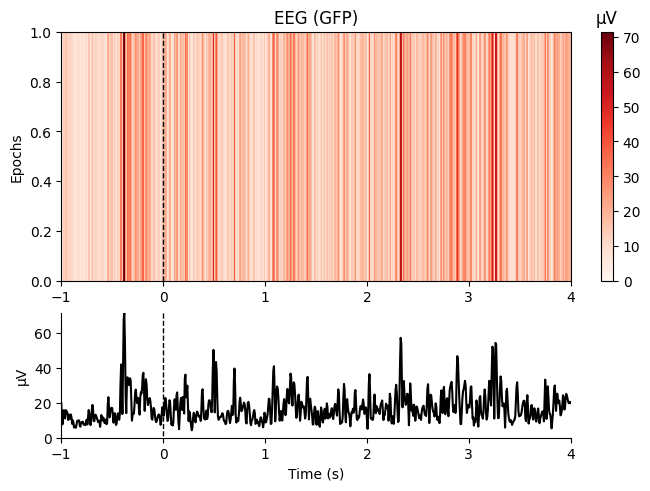

[<Figure size 640x480 with 3 Axes>]

In [4]:
epochs[0].plot_image()

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

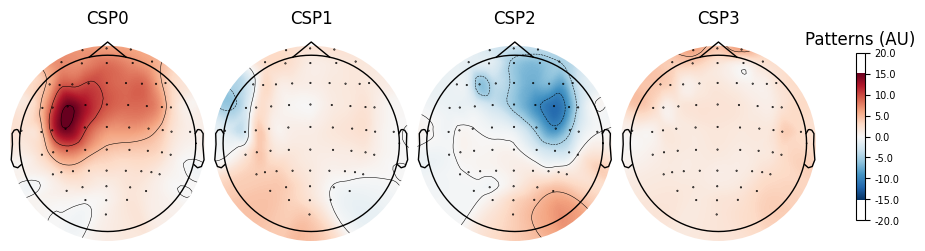

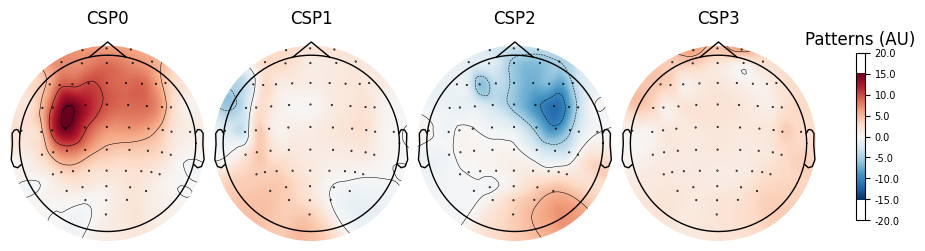

In [5]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [6]:
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

Classification accuracy: 0.9333333333333333 / Chance level: 0.5333333333333333


In [7]:
#raw.compute_psd().plot()

In [8]:
#epochs_train.plot_image()

Computing rank from data with rank=None
    Using tolerance 9.7e-05 (2.2e-16 eps * 64 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.3e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5e-05 (2.2e-16 eps * 64 dim * 6.7e+09  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0001 (2.2e-16 eps * 64 dim * 7.2e+09  max singular value)
  

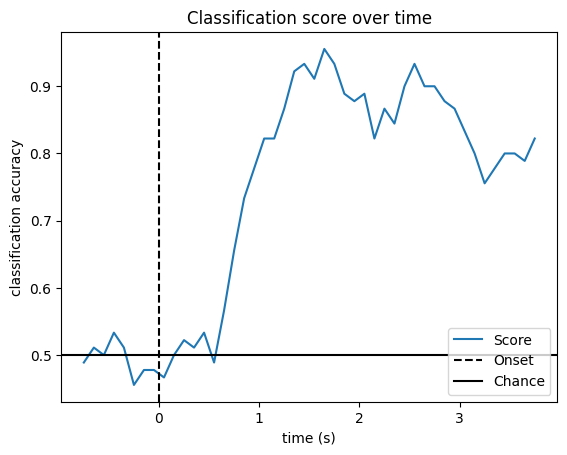

In [9]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [10]:
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [11]:
# cross validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
# get epochs
#epochs_data_train = 1e6 * epochs.get_data(copy=False) 

# compute covariance matrices
#cov_data_train = Covariances().transform(epochs_train)

In [12]:
# Assemble a classifier
lr = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)

clf = Pipeline([('CSP', csp), ('LogisticRegression', lr)])
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" %
      (np.mean(scores), class_balance))

Computing rank from data with rank=None
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.


Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.8e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular v

In [13]:
import pywt

def extract_wavelet_features(epochs, sampling_freq, wavelet='db4', num_levels=4):
    """
    Extract wavelet features from EEG epochs.

    Args:
        epochs (np.ndarray): 3D array of EEG epochs with shape (n_epochs, n_channels, n_samples)
        sampling_freq (float): Sampling frequency of the EEG data
        wavelet (str): Name of the wavelet family to use (default: 'db4')
        num_levels (int): Number of wavelet decomposition levels (default: 4)

    Returns:
        np.ndarray: 2D array of wavelet features with shape (n_epochs, n_features)
    """
    n_epochs, n_channels, n_samples = epochs.shape
    features = []

    for epoch in epochs:
        epoch_features = []
        for channel in epoch:
            # Perform wavelet decomposition
            coeffs = pywt.wavedec(channel, wavelet, level=num_levels)

            # Extract features from the detail coefficients
            channel_features = []
            for level in range(num_levels):
                detail_coeffs = coeffs[level]
                channel_features.extend([
                    np.mean(np.abs(detail_coeffs)),  # Mean of absolute values
                    np.std(detail_coeffs),  # Standard deviation
                    np.max(np.abs(detail_coeffs)),  # Maximum of absolute values
                ])

            epoch_features.append(channel_features)

        epoch_features = np.concatenate(epoch_features)
        features.append(epoch_features)

    features = np.array(features)
    return features

In [14]:
#svm classifier
from sklearn.svm import SVC

# import numpy as np
# from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#wavelet_features = extract_wavelet_features(epochs_data, sampling_freq=epochs.info['sfreq'])

# 2. Create a custom transformer class for wavelet feature extraction
from sklearn.base import BaseEstimator, TransformerMixin

class WaveletTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return extract_wavelet_features(X, sampling_freq=epochs.info['sfreq'])


wavelet_transformer = WaveletTransformer()
svm = SVC(kernel='rbf', gamma='auto', C=1.0)

clf = Pipeline([("Wavelet", wavelet_transformer), ("SVM", svm)])
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)

# Printing the results
# class_balance = np.mean(labels == labels[0])
# class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" %
      (np.mean(scores), class_balance))


CSP + LDA Classification accuracy: 0.520000 / Chance level: 0.533333


In [15]:
# now try csp + svm
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)
svm = SVC(kernel='rbf', gamma='auto', C=1.0)
clf = Pipeline([('CSP', csp), ('SVM', svm)])
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=1)
print("CSP + SVM Classification accuracy: %f / Chance level: %f" %
        (np.mean(scores), class_balance))

Computing rank from data with rank=None


    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.8e+10  max singular value)
    Estimated rank (mag): 64
    M

## EEG Conformer


In [16]:
from braindecode.datasets import (
    create_from_mne_raw, create_from_mne_epochs)
from braindecode.preprocessing import create_windows_from_events
import mne
from mne.preprocessing import ICA
import sys

from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib_inline


sys.path.append('../models')

from eegconformer import EEGConformer




local


In [17]:
epochs_data.shape

(45, 64, 801)

In [18]:
from sklearn.preprocessing import RobustScaler
import torch

# Assuming 'epochs_train' contains your epochs of interest

# Step 1: Extract EEG data from epochs
eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
print(eeg_data.shape)

# Step 2: Scale the EEG data
# Flatten the data for scaling, then scale, and reshape back
scaler = RobustScaler()
eeg_data_flattened = eeg_data.reshape(eeg_data.shape[0], -1)  # Flatten
eeg_data_scaled = scaler.fit_transform(eeg_data_flattened)
eeg_data_scaled = eeg_data_scaled.reshape(eeg_data.shape)  # Reshape back

# Step 3: Prepare labels
# You might need to adjust this depending on how you've determined your labels
labels = epochs.events[:, -1] - 2  # Adjust based on your specific labeling

# # Step 4: Convert to PyTorch tensors
# eeg_data_tensor = torch.tensor(eeg_data_scaled).float()
# labels_tensor = torch.tensor(labels).long()  # Using .long() for labels if you're using them for classification

# Now, 'eeg_data_tensor' and 'labels_tensor' are ready for use in your model training process


(45, 64, 801)


C:\Users\Hannah\AppData\Local\Temp\ipykernel_3568\1042700850.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming eeg_data_scaled is your scaled EEG data in NumPy array format
# and labels is a NumPy array of your labels

# Split the data and labels into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(
    eeg_data_scaled,  # Scaled EEG data
    labels,  # Labels
    test_size=0.2,  # Specifies 20% of the data for testing
    random_state=42  # Ensures reproducibility of your split
)
# Encode the training and testing labels
le = LabelEncoder()
encoded_train_y = le.fit_transform(train_y)
encoded_test_y = le.transform(test_y)

# One-hot encode the encoded labels
train_y = pd.get_dummies(encoded_train_y)
test_y = pd.get_dummies(encoded_test_y)

In [20]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((36, 64, 801), (9, 64, 801), (36, 2), (9, 2))

In [21]:
# import torch
# from torch.utils.data import TensorDataset, DataLoader, random_split

# # Calculate the sizes of each subset
# total_size = len(eeg_data_tensor)
# train_size = int(0.8 * total_size)
# test_size = total_size - train_size

# # Create a TensorDataset
# dataset = TensorDataset(eeg_data_tensor, labels_tensor)

# # Split the dataset into training and testing sets
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# # Optional: Create DataLoaders if you want to batch your data during training/testing
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [22]:
cuda = torch.cuda.is_available()
print(cuda)
device = "cuda" if cuda else "cpu"

False


In [23]:

cuda_version = torch.version.cuda
cuda_version

In [24]:
seed = 20240216

model = EEGConformer(
    n_outputs=3,
    n_chans=64,
    sfreq=160,
    n_times = epochs_data.shape[2],
    n_filters_time=40, 
    filter_time_length=25,
    pool_time_length=75,
    pool_time_stride=15,
    drop_prob=0.7,
    att_depth=3,
    att_heads=10,
    att_drop_prob=0.7,
    final_fc_length='auto', # could be 'auto' or int
    return_features=False, # returns the features before the last classification layer if True
    chs_info=None,
    input_window_seconds=None,
    add_log_softmax=True,
)

print(model)

Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                  [1, 64, 801]              [1, 3]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 64, 801]           [1, 47, 40]               --                        --
│    └─Sequential (shallownet): 2-1                          [1, 1, 64, 801]           [1, 40, 1, 47]            --                        --
│    │    └─Conv2d (0): 3-1                                  [1, 1, 64, 801]           [1, 40, 64, 777]          1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                  [1, 40, 64, 777]          [1, 40, 1, 777]           102,440                   [64, 1]
│    │    └─BatchNorm2d (2): 3-3                             [1, 40, 1, 777]           [1, 40, 1, 777]           80             

c:\Users\Hannah\OneDrive\Documents\GitHub\eeg\notebooks\../models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [25]:
if cuda:
    model.cuda()

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np



batch_size = 64

# Convert pandas dataframe (.values) to numpy, then find argmax if one-hot encoded
if len(train_y.shape) > 1:  # Check if train_y is one-hot encoded
    train_y_indices = np.argmax(train_y.values, axis=1)
else:
    train_y_indices = train_y.values  # Assuming it's already appropriate format

if len(test_y.shape) > 1:  # Check if test_y is one-hot encoded
    test_y_indices = np.argmax(test_y.values, axis=1)
else:
    test_y_indices = test_y.values  # Assuming it's already appropriate format

# Convert features and labels to tensors
x_train_tensor = torch.from_numpy(train_X).to(torch.float32).to(device)
y_train_tensor = torch.tensor(train_y_indices).to(torch.long).to(device)  # Use torch.long for class indices

x_test_tensor = torch.from_numpy(test_X).to(torch.float32).to(device)
y_test_tensor = torch.tensor(test_y_indices).to(torch.long).to(device)  # Use torch.long for class indices

# Create datasets and loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.999))


In [27]:
def train(model, x_train, y_train, x_test, y_test, save_path='../models/', n_epochs=100):
    """
    the training function.
    Attributes:
    - model: the instance of the network
    - save_path: the path to which the model state will be saved. None means w/o saving.

    Return: 
    the best model if save_path is not None, the last model otherwise
    """
    train_acc_list = []
    train_loss_list = []
    test_acc_list = []
    test_loss_list = []


    best_accuracy = 0.0
    
    for epoch in range(n_epochs):
        model.train()  # Set model to training mode
        training_loss = 0.0
        total = 0
        correct = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Update correction on how labels are handled
        
        train_loss = training_loss / len(train_loader)
        train_accuracy = correct / total
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        
        model.eval()  # Set model to evaluation mode
        testing_loss = 0.0
        total = 0
        correct = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                testing_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
            test_loss = testing_loss / len(test_loader)
            test_accuracy = correct / total
            test_acc_list.append(test_accuracy)
            test_loss_list.append(test_loss)
            
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_model_wts = model.state_dict()
        
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    if save_path is not None and best_accuracy > 0:
        torch.save(best_model_wts, save_path + 'best_model.pth')
        print("Best model saved with accuracy: {:.4f}".format(best_accuracy))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_list, train_loss_list, test_acc_list, test_loss_list

In [28]:
best_model, train_acc_list, train_loss_list, test_acc_list, test_loss_list = train(model, train_X, test_X, train_y, test_y, n_epochs=1000)


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 1/1000 - Train Loss: 1.0987, Train Accuracy: 0.3611, Test Loss: 1.0674, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 2/1000 - Train Loss: 1.0775, Train Accuracy: 0.4722, Test Loss: 1.0047, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 3/1000 - Train Loss: 1.0143, Train Accuracy: 0.3611, Test Loss: 0.9606, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 4/1000 - Train Loss: 1.0134, Train Accuracy: 0.3333, Test Loss: 0.9279, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 5/1000 - Train Loss: 0.9859, Train Accuracy: 0.4722, Test Loss: 0.9014, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 6/1000 - Train Loss: 0.9048, Train Accuracy: 0.4722, Test Loss: 0.8834, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 7/1000 - Train Loss: 0.8441, Train Accuracy: 0.5833, Test Loss: 0.8687, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 8/1000 - Train Loss: 0.9113, Train Accuracy: 0.5000, Test Loss: 0.8606, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 9/1000 - Train Loss: 0.7962, Train Accuracy: 0.5000, Test Loss: 0.8576, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Epoch 10/1000 - Train Loss: 0.7593, Train Accuracy: 0.6111, Test Loss: 0.8613, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 11/1000 - Train Loss: 0.7790, Train Accuracy: 0.5000, Test Loss: 0.8662, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 12/1000 - Train Loss: 0.7755, Train Accuracy: 0.5278, Test Loss: 0.8752, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 13/1000 - Train Loss: 0.7420, Train Accuracy: 0.5556, Test Loss: 0.8802, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 14/1000 - Train Loss: 0.6778, Train Accuracy: 0.6667, Test Loss: 0.8838, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 15/1000 - Train Loss: 0.7805, Train Accuracy: 0.5278, Test Loss: 0.8875, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 16/1000 - Train Loss: 0.6086, Train Accuracy: 0.7778, Test Loss: 0.8866, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 17/1000 - Train Loss: 0.7490, Train Accuracy: 0.5833, Test Loss: 0.8811, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 18/1000 - Train Loss: 0.8027, Train Accuracy: 0.5000, Test Loss: 0.8638, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 19/1000 - Train Loss: 0.8173, Train Accuracy: 0.6111, Test Loss: 0.8429, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch 20/1000 - Train Loss: 0.7226, Train Accuracy: 0.5833, Test Loss: 0.8219, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 21/1000 - Train Loss: 0.7201, Train Accuracy: 0.6111, Test Loss: 0.8048, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch 22/1000 - Train Loss: 0.6868, Train Accuracy: 0.6111, Test Loss: 0.7864, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 23/1000 - Train Loss: 0.8321, Train Accuracy: 0.4167, Test Loss: 0.7721, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch 24/1000 - Train Loss: 0.7575, Train Accuracy: 0.5278, Test Loss: 0.7581, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 25/1000 - Train Loss: 0.6761, Train Accuracy: 0.6111, Test Loss: 0.7445, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch 26/1000 - Train Loss: 0.7659, Train Accuracy: 0.4444, Test Loss: 0.7354, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 27/1000 - Train Loss: 0.7733, Train Accuracy: 0.5278, Test Loss: 0.7296, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Epoch 28/1000 - Train Loss: 0.6682, Train Accuracy: 0.7500, Test Loss: 0.7263, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 29/1000 - Train Loss: 0.7651, Train Accuracy: 0.4722, Test Loss: 0.7222, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch 30/1000 - Train Loss: 0.7278, Train Accuracy: 0.4722, Test Loss: 0.7212, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 31/1000 - Train Loss: 0.6367, Train Accuracy: 0.6111, Test Loss: 0.7235, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 32/1000 - Train Loss: 0.7202, Train Accuracy: 0.5278, Test Loss: 0.7320, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 33/1000 - Train Loss: 0.7343, Train Accuracy: 0.4722, Test Loss: 0.7393, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 34/1000 - Train Loss: 0.7238, Train Accuracy: 0.5000, Test Loss: 0.7512, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 35/1000 - Train Loss: 0.7422, Train Accuracy: 0.5000, Test Loss: 0.7692, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch 36/1000 - Train Loss: 0.7497, Train Accuracy: 0.5000, Test Loss: 0.7899, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 37/1000 - Train Loss: 0.6646, Train Accuracy: 0.5833, Test Loss: 0.8069, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 38/1000 - Train Loss: 0.6973, Train Accuracy: 0.5556, Test Loss: 0.8238, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 39/1000 - Train Loss: 0.7428, Train Accuracy: 0.5556, Test Loss: 0.8330, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch 40/1000 - Train Loss: 0.6918, Train Accuracy: 0.5278, Test Loss: 0.8403, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch 41/1000 - Train Loss: 0.7258, Train Accuracy: 0.5278, Test Loss: 0.8424, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 42/1000 - Train Loss: 0.7085, Train Accuracy: 0.6667, Test Loss: 0.8382, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 43/1000 - Train Loss: 0.6652, Train Accuracy: 0.6389, Test Loss: 0.8275, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 44/1000 - Train Loss: 0.7013, Train Accuracy: 0.5833, Test Loss: 0.8118, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 45/1000 - Train Loss: 0.6983, Train Accuracy: 0.5556, Test Loss: 0.7921, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Epoch 46/1000 - Train Loss: 0.6996, Train Accuracy: 0.5833, Test Loss: 0.7791, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 47/1000 - Train Loss: 0.6456, Train Accuracy: 0.6667, Test Loss: 0.7726, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch 48/1000 - Train Loss: 0.6627, Train Accuracy: 0.6944, Test Loss: 0.7659, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch 49/1000 - Train Loss: 0.6710, Train Accuracy: 0.5556, Test Loss: 0.7613, Test Accuracy: 0.3333


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 50/1000 - Train Loss: 0.7560, Train Accuracy: 0.5000, Test Loss: 0.7567, Test Accuracy: 0.3333


  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 0, 'epoch')

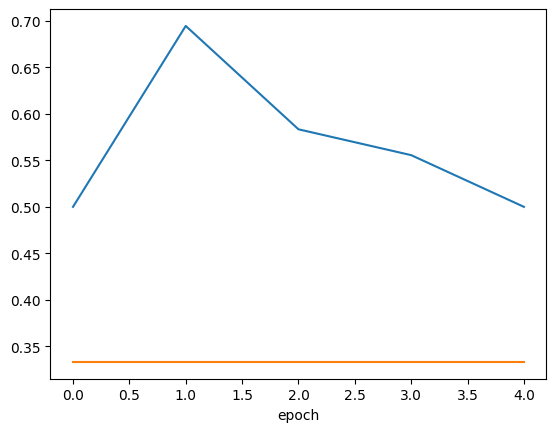

In [ ]:
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

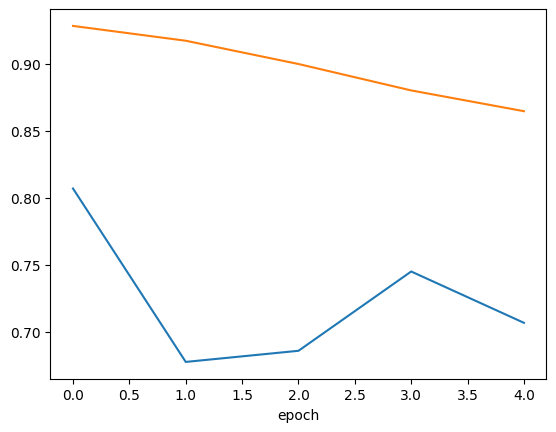

In [ ]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.xlabel('epoch')

In [ ]:
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # Remove the incorrect line attempting to use torch.max on labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Compare predicted directly to labels
    
    test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.3333
